In [1]:
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
from ristretto.svd import compute_rsvd

## Load 9 days of data from start of 2019

In [18]:
current_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2019, 1, 10)
increment = dt.timedelta(days=1)
arr = None

In [19]:
date = dt.datetime(2019, 6, 1)
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(date)[:10] + ".nc4")
    darr = data.to_array()
    if arr is None:
        arr = darr[0, :, 0, :, :]
    else:
        arr = xr.concat([arr, darr[0, :, 0, :, :]], dim="time")
    del darr
    next_date = current_date + increment
    current_date = next_date

working on 2019-01-01 00:00:00
working on 2019-01-02 00:00:00
working on 2019-01-03 00:00:00
working on 2019-01-04 00:00:00
working on 2019-01-05 00:00:00
working on 2019-01-06 00:00:00
working on 2019-01-07 00:00:00
working on 2019-01-08 00:00:00
working on 2019-01-09 00:00:00


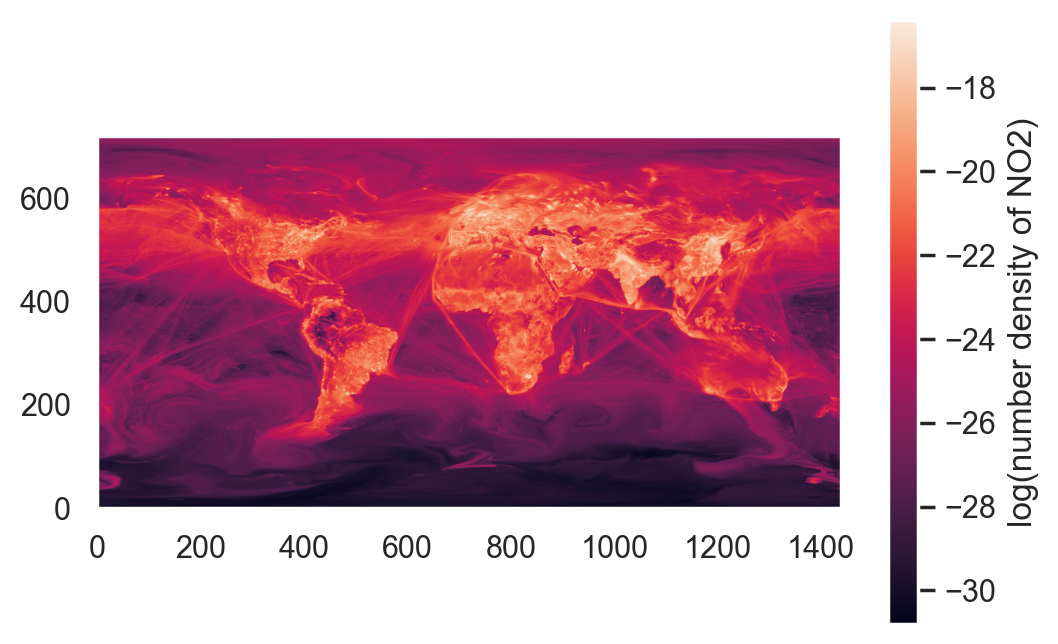

In [32]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
%matplotlib inline
plt.figure(dpi=200)
plt.grid()
plt.imshow(np.log(arr[0, :, :]), origin="lower")
plt.colorbar(label="log(number density of NO2)")
plt.show()

In [34]:
plt.savefig(f"figures/{date.year}.{date.month}.{date.day}_map.png")

<Figure size 432x288 with 0 Axes>

In [46]:
nparr = np.log(arr.to_numpy() + 1e-30)
A = nparr.reshape([nparr.shape[0], nparr.shape[1] * nparr.shape[2]]).T
A.shape

(1038240, 216)

In [2]:
compute_rsvd?

Object `compute_rsvd` not found.


### Matrix Energy

In [77]:
rank = 100
U, s, Vt = compute_rsvd(A, rank, random_state=633)

In [78]:
A.shape

(1038240, 216)

In [84]:
min_s = s[-1]
# basically I'm assuming all the unkown singular values are as large as possible
total_energy_upper_bound = sum(s) + (A.shape[1] - rank) * min_s

In [85]:
energies = []
for r in range(rank):  # try smaller rank decompositions
    energies.append(sum(s[:r + 1]) * 100 / total_energy_upper_bound)

<IPython.core.display.Javascript object>


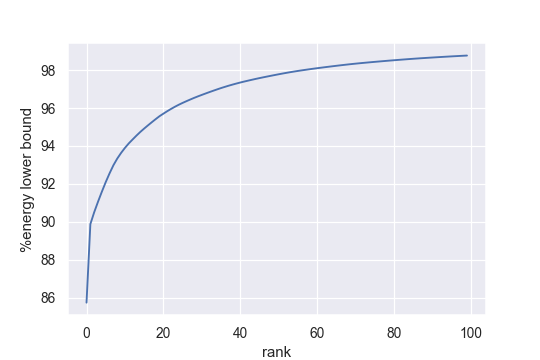

In [138]:
%matplotlib notebook
plt.figure(dpi=120)
plt.plot(energies)
plt.xlabel("rank")
plt.ylabel("%energy lower bound")
plt.show()

In [139]:
plt.savefig("figures/9day_energy_plot.png")

In [58]:
U.shape

(1038240, 30)

In [83]:
U_ims = U.reshape((nparr.shape[1], nparr.shape[2], U.shape[1]))

In [108]:
U_ims[:, :, 0] / U_ims[:, :, 1]

array([[0.99223256, 0.9925369 , 0.9924788 , ..., 0.9924788 , 0.9924788 ,
        0.9924788 ],
       [0.9835084 , 0.9835153 , 0.983522  , ..., 0.9835004 , 0.9835135 ,
        0.9835148 ],
       [0.974563  , 0.9745851 , 0.97459865, ..., 0.974517  , 0.974519  ,
        0.9745288 ],
       ...,
       [1.1738155 , 1.1735897 , 1.1732826 , ..., 1.1746228 , 1.174326  ,
        1.1740878 ],
       [1.2684441 , 1.268243  , 1.2680482 , ..., 1.2690634 , 1.2688599 ,
        1.2686226 ],
       [2.0089023 , 2.0089023 , 2.0089023 , ..., 2.008907  , 2.0089023 ,
        2.0089023 ]], dtype=float32)

In [128]:
np.sum(U_ims[:, :, 1] ** 2)

1.0000001

<IPython.core.display.Javascript object>


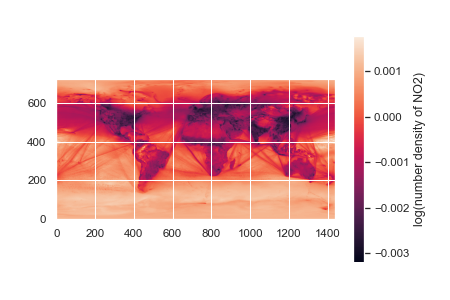

In [137]:
spatial_mode = 10
plt.figure(dpi=100)
plt.imshow(U_ims[:, :, spatial_mode], origin="lower")
plt.colorbar(label="log(number density of NO2)")
plt.show()

In [118]:
plt.savefig(f"figures/2019Jan1-Jan9_spatial_mode{spatial_mode}.png")

# 2018-19 combined

In [5]:
np.random.seed(633)

k = 200  # generate k columns that are randomly weighted combinations of columns in the full dataset

current_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2020, 1, 1)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24


imshape = (4 * 180 + 1, 360 * 4)
dim = imshape[0] * imshape[1]  # 1038240

## first find where there is missing data


In [107]:
current_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2020, 1, 1)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
valid_times = pd.DatetimeIndex([])

while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :]  # remove elev and species dimensions
    nparr = darr.to_numpy()
    flattened = nparr.reshape((nparr.shape[0], nparr.shape[1] * nparr.shape[2])).T  # flatten image
    
    is_data = np.nonzero(np.sum(flattened, axis=0))
    time = pd.to_datetime(darr.time) - dt.timedelta(minutes=30)
    valid_times = valid_times.append(time[is_data]) 
    current_date += increment


working on 2018-01-01 00:00:00
working on 2018-01-02 00:00:00
working on 2018-01-03 00:00:00
working on 2018-01-04 00:00:00
working on 2018-01-05 00:00:00
working on 2018-01-06 00:00:00
working on 2018-01-07 00:00:00
working on 2018-01-08 00:00:00
working on 2018-01-09 00:00:00
working on 2018-01-10 00:00:00
working on 2018-01-11 00:00:00
working on 2018-01-12 00:00:00
working on 2018-01-13 00:00:00
working on 2018-01-14 00:00:00
working on 2018-01-15 00:00:00
working on 2018-01-16 00:00:00
working on 2018-01-17 00:00:00
working on 2018-01-18 00:00:00
working on 2018-01-19 00:00:00
working on 2018-01-20 00:00:00
working on 2018-01-21 00:00:00
working on 2018-01-22 00:00:00
working on 2018-01-23 00:00:00
working on 2018-01-24 00:00:00
working on 2018-01-25 00:00:00
working on 2018-01-26 00:00:00
working on 2018-01-27 00:00:00
working on 2018-01-28 00:00:00
working on 2018-01-29 00:00:00
working on 2018-01-30 00:00:00
working on 2018-01-31 00:00:00
working on 2018-02-01 00:00:00
working 

In [109]:
np.save("2018-19_valid_times.npy", valid_times.to_numpy())

omega is T x k, but we break it into T / 24 omega_i matrices that are 24 x k

each column of omega sums to 1

In [114]:
# define random sampling matrix
omega = np.random.random(size=(T, k))
omega /= np.sum(omega, axis=0)

arr = np.zeros((dim, k))

i = 0
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :]  # remove elev and species dimensions
    nparr = np.log(darr.to_numpy() + 1e-30)
    A = nparr.reshape([nparr.shape[0], nparr.shape[1] * nparr.shape[2]]).T
    sampled = A @ omega[i * 24: (i + 1) * 24, :]
    arr += sampled
    del darr, nparr, A, sampled
    current_date += increment
    i += 1

working on 2018-01-01 00:00:00
working on 2018-01-02 00:00:00
working on 2018-01-03 00:00:00
working on 2018-01-04 00:00:00
working on 2018-01-05 00:00:00
working on 2018-01-06 00:00:00
working on 2018-01-07 00:00:00
working on 2018-01-08 00:00:00
working on 2018-01-09 00:00:00
working on 2018-01-10 00:00:00
working on 2018-01-11 00:00:00
working on 2018-01-12 00:00:00
working on 2018-01-13 00:00:00
working on 2018-01-14 00:00:00
working on 2018-01-15 00:00:00
working on 2018-01-16 00:00:00
working on 2018-01-17 00:00:00
working on 2018-01-18 00:00:00
working on 2018-01-19 00:00:00
working on 2018-01-20 00:00:00
working on 2018-01-21 00:00:00
working on 2018-01-22 00:00:00
working on 2018-01-23 00:00:00
working on 2018-01-24 00:00:00
working on 2018-01-25 00:00:00
working on 2018-01-26 00:00:00
working on 2018-01-27 00:00:00
working on 2018-01-28 00:00:00
working on 2018-01-29 00:00:00
working on 2018-01-30 00:00:00
working on 2018-01-31 00:00:00
working on 2018-02-01 00:00:00
working 

## Compute RSVD of the random arr


In [118]:
spatial_means = arr.mean(axis=1, keepdims=True)
A = arr - spatial_means

rank = 200
# U, s, Vt = compute_rsvd(A, rank, random_state=633)
U, s, Vt = np.linalg.svd(A, full_matrices=False)

In [119]:
np.save("2018-19_spatial_means.npy", spatial_means)

 To get a better approx of explained variance: https://arxiv.org/abs/1903.11543

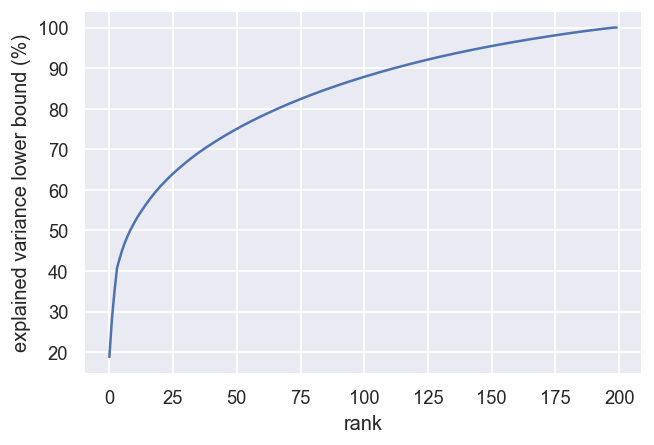

In [122]:
min_s = s[-1]
# basically I'm assuming all the unkown singular values are as large as possible
total_variance_upper_bound = sum(s**2) + (T - rank) * min_s**2

energies = []
for r in range(rank):  # try smaller rank decompositions
    energies.append(sum(s[:r + 1]**2) * 100 / total_variance_upper_bound)

plt.figure(dpi=120)
plt.plot(energies)
plt.xlabel("rank")
plt.ylabel("explained variance lower bound (%)")
plt.show()

In [127]:
plt.savefig("figures/2018-19_explained_variance.png")

np.save(f"D:/atmo-chem/2018-19_rank{rank}U.npy", U)

<Figure size 432x288 with 0 Axes>

In [128]:
np.save(f"2018-19_rank{rank}sigmas.npy", s)

In [130]:
s = np.load(f"2018-19_rank{rank}sigmas.npy")

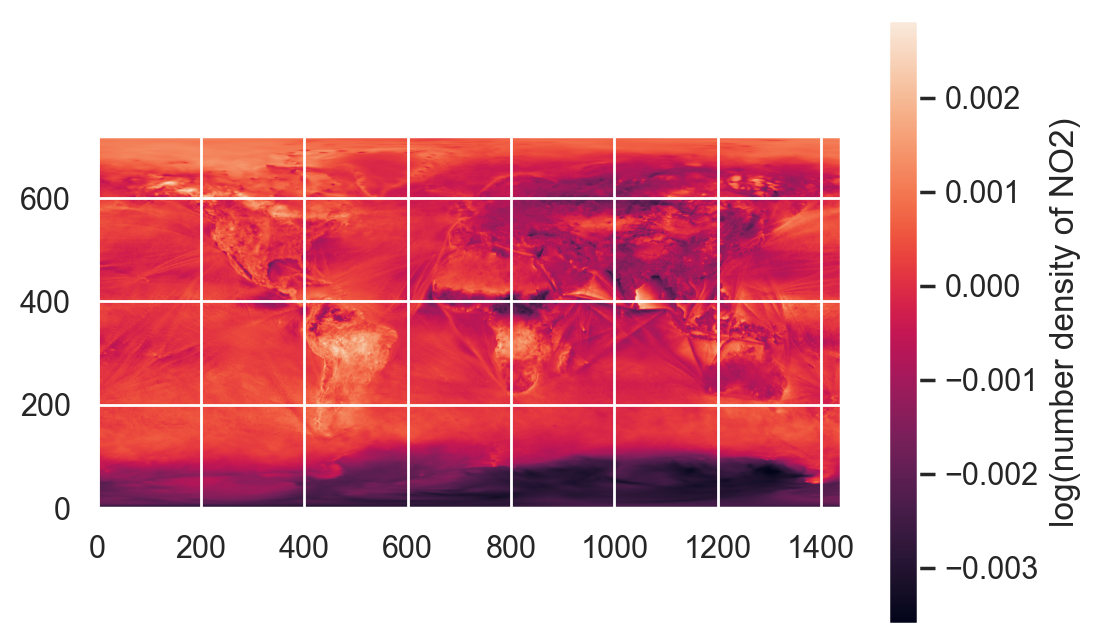

<Figure size 432x288 with 0 Axes>

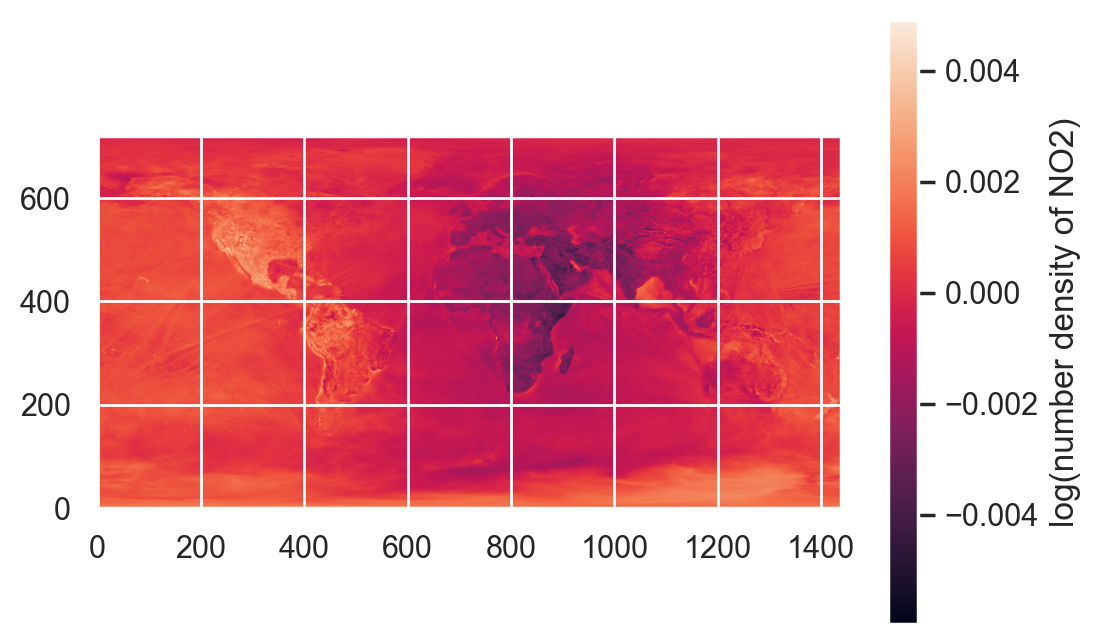

<Figure size 432x288 with 0 Axes>

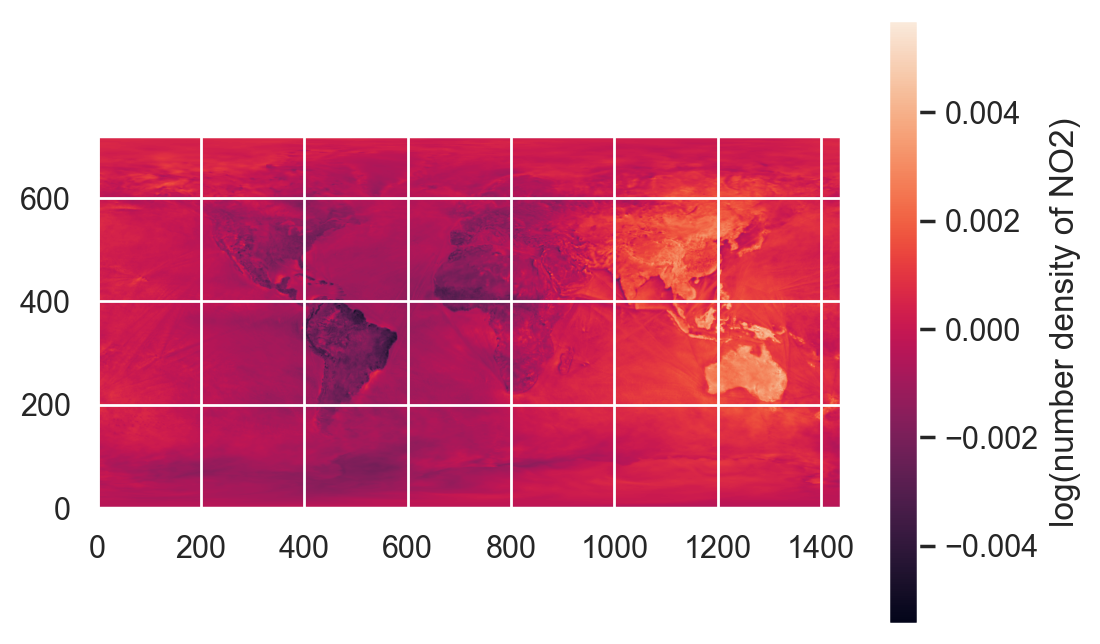

<Figure size 432x288 with 0 Axes>

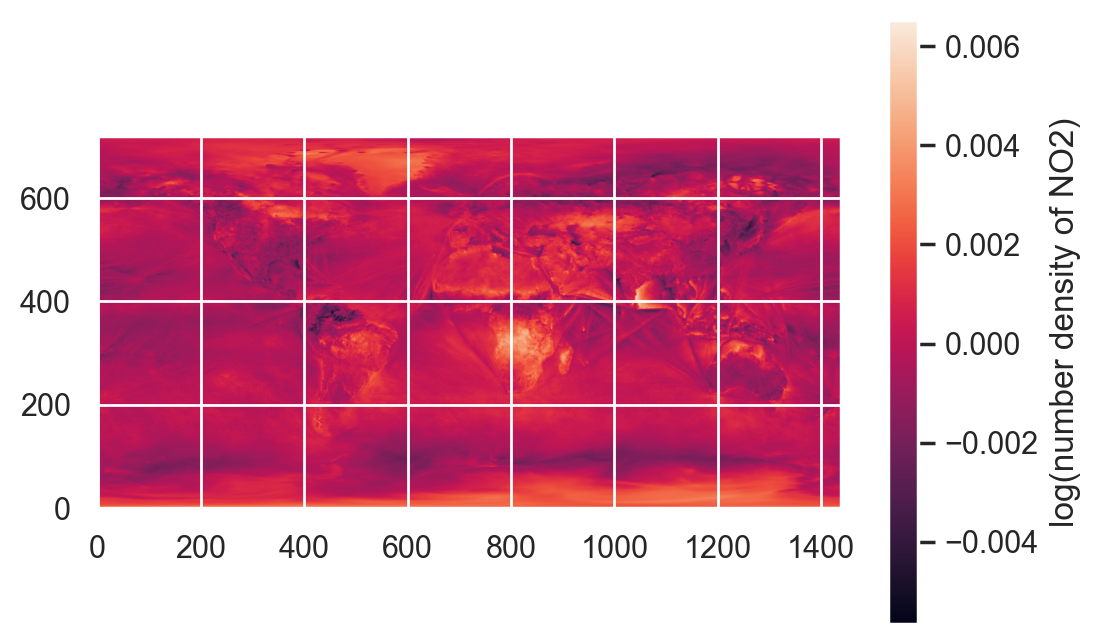

<Figure size 432x288 with 0 Axes>

In [132]:
U_ims = U.reshape((imshape[0], imshape[1], U.shape[1]))

for spatial_mode in range(4):
    plt.figure(dpi=200)
    plt.imshow(U_ims[:, :, spatial_mode], origin="lower")
    plt.colorbar(label="log(number density of NO2)")
    plt.show()

    plt.savefig(f"figures/2018-19_spatial_mode{spatial_mode}.png")

In [133]:
plt.close("all")

## Project all observations onto U-space

In [134]:
U = np.load(f"D:/atmo-chem/2018-19_rank{rank}U.npy")

U.shape

(1038240, 200)

In [135]:
current_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2020, 1, 1)
increment = dt.timedelta(days=1)  # each file contains 1 day of data

T = ((end_date - current_date).days) * 24
V = np.zeros((T, rank))  # --temporal modes--should see some quasi-periodicity
# V = pd.DataFrame(np.zeros((T, rank)).T)  
# V.index = pd.date_range(current_date, end_date, freq="H", closed="left")

In [136]:
t = 0
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    
    A = np.log(flattened + 1e-30) - spatial_means
    V[t:t + A.shape[1], :] = (U.T @ A).T 
    current_date += increment
    t += A.shape[1]
# #     del darr, nparr, A
V = V @ np.diag(1 / s) # otherwise it would be V @ Sigma

working on 2018-01-01 00:00:00
working on 2018-01-02 00:00:00
working on 2018-01-03 00:00:00
working on 2018-01-04 00:00:00
working on 2018-01-05 00:00:00
working on 2018-01-06 00:00:00
working on 2018-01-07 00:00:00
working on 2018-01-08 00:00:00
working on 2018-01-09 00:00:00
working on 2018-01-10 00:00:00
working on 2018-01-11 00:00:00
working on 2018-01-12 00:00:00
working on 2018-01-13 00:00:00
working on 2018-01-14 00:00:00
working on 2018-01-15 00:00:00
working on 2018-01-16 00:00:00
working on 2018-01-17 00:00:00
working on 2018-01-18 00:00:00
working on 2018-01-19 00:00:00
working on 2018-01-20 00:00:00
working on 2018-01-21 00:00:00
working on 2018-01-22 00:00:00
working on 2018-01-23 00:00:00
working on 2018-01-24 00:00:00
working on 2018-01-25 00:00:00
working on 2018-01-26 00:00:00
working on 2018-01-27 00:00:00
working on 2018-01-28 00:00:00
working on 2018-01-29 00:00:00
working on 2018-01-30 00:00:00
working on 2018-01-31 00:00:00
working on 2018-02-01 00:00:00
working 

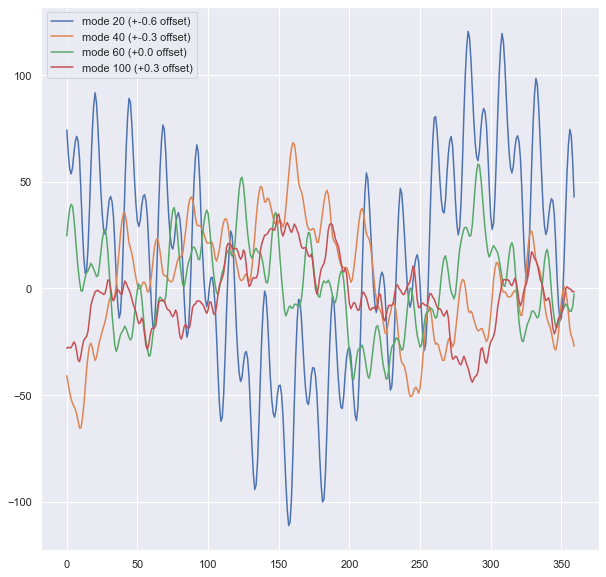

In [138]:
%matplotlib inline
plt.figure(figsize=(10, 10))

modes = [20, 40, 60, 100]
offset = -len(modes) // 2 * 0.3
for i in modes:
    plt.plot(s[i - 1] * V[:24 * 15, i-1] + offset, label=f"mode {i} (+{offset} offset)")
    offset += 0.3
plt.legend()

In [139]:
np.save(f"2018-19_rank{rank}V.npy", V)

# Test reconstruction of several random snapshots
Measure something intuitively interpretable about how similar the images are, like explained variance

How much of the variance of each pixel with time is explained by the low rank SVD: 
- if PCA reconstruction takes linear combinations of uncorrelated modes, then adding new modes can only increase the variance
- explained variance ~= variance of a rank-k reconstruction of a pixel / observed variance of that pixel


In [7]:
np.random.seed(633)
num_random_pixels = 1000
random_pixels = np.random.randint(low=0, high=dim, size=num_random_pixels)

In [16]:
rank=200
V = np.load(f"2018-19_rank{rank}V.npy")
s = np.load(f"2018-19_rank{rank}sigmas.npy")
U = np.load(f"D:/atmo-chem/2018-19_rank{rank}U.npy")
spatial_means = np.load("2018-19_spatial_means.npy")
V.shape, U.shape

((17520, 200), (1038240, 200))

In [17]:
sampled_U = U[random_pixels, :]
del U  # about a GB of memory
sampled_U.shape

(1000, 200)

In [25]:
observed = np.zeros((num_random_pixels, T))

In [28]:
np.save(f"2018-19_observed_sample{num_random_pixels}.npy", observed)

In [20]:
observed = np.load(f"2018-19_observed_sample{num_random_pixels}.npy")

In [26]:
t = 0
current_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2020, 1, 1)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    flattened[:, np.sum(flattened, axis=0) == 0] = np.nan  # deal with missing data by setting it to nan
    
    A = np.log(flattened + 1e-30) - spatial_means
    observed[:, t:t + A.shape[1]] = A[random_pixels, :]

    current_date += increment
    t += A.shape[1]
#     del darr, nparr, A

working on 2018-01-01 00:00:00
working on 2018-01-02 00:00:00
working on 2018-01-03 00:00:00
working on 2018-01-04 00:00:00
working on 2018-01-05 00:00:00
working on 2018-01-06 00:00:00
working on 2018-01-07 00:00:00
working on 2018-01-08 00:00:00
working on 2018-01-09 00:00:00
working on 2018-01-10 00:00:00
working on 2018-01-11 00:00:00
working on 2018-01-12 00:00:00
working on 2018-01-13 00:00:00
working on 2018-01-14 00:00:00
working on 2018-01-15 00:00:00
working on 2018-01-16 00:00:00
working on 2018-01-17 00:00:00
working on 2018-01-18 00:00:00
working on 2018-01-19 00:00:00
working on 2018-01-20 00:00:00
working on 2018-01-21 00:00:00
working on 2018-01-22 00:00:00
working on 2018-01-23 00:00:00
working on 2018-01-24 00:00:00
working on 2018-01-25 00:00:00
working on 2018-01-26 00:00:00
working on 2018-01-27 00:00:00
working on 2018-01-28 00:00:00
working on 2018-01-29 00:00:00
working on 2018-01-30 00:00:00
working on 2018-01-31 00:00:00
working on 2018-02-01 00:00:00
working 

In [18]:
reconstructed_vars = np.zeros((rank, num_random_pixels))
# try various ranks
for r in range(rank):
    reconstructed = sampled_U[:, :r] @ np.diag(s[:r]) @ V.T[:r, :]
    reconstructed_vars[r, :] = np.var(reconstructed, axis=1)
    

In [19]:
reconstructed_vars

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12484152, 0.04293284, 0.91998983, ..., 0.05490071, 0.10787022,
        0.02828831],
       [0.12810194, 0.0480624 , 1.18409489, ..., 0.06082902, 0.1081701 ,
        0.03173585],
       ...,
       [0.53132228, 0.59412844, 1.47568432, ..., 1.20994389, 0.41612269,
        0.18017917],
       [0.53281996, 0.59360015, 1.47567782, ..., 1.21084026, 0.41584125,
        0.17988249],
       [0.53520845, 0.59415145, 1.47546043, ..., 1.21107375, 0.41581653,
        0.17981128]])

In [36]:
r = 100
observed_var = np.var(observed, axis=1)
reconstructed_var = reconstructed_vars[r - 1]
np.mean(reconstructed_var) / np.mean(observed_var)

0.598339973217759

In [44]:
np.mean(observed, axis=None), np.mean(reconstructed, axis=None)

(1.2797563195917594e-05, 1.743881638170929e-05)

In [134]:
from scipy.stats import pearsonr

In [43]:
V[:, :30].T @ V[:, :30]

array([[ 4.67185273e+06, -5.52355806e+05,  7.99726731e+05,
        -6.21489108e+04, -1.29274653e+05,  1.38437377e+05,
         1.32453963e+05, -3.15240062e+04, -2.71514012e+05,
         2.38557649e+05,  3.28401366e+05, -1.07060715e+05,
         1.68346712e+05,  7.17204332e+04,  1.00835706e+04,
         2.33288774e+05, -1.43373642e+05,  1.10737480e+04,
         3.35245490e+05, -3.90305565e+05, -1.60038329e+05,
         2.57691756e+05, -4.67648504e+05, -1.54657269e+05,
         1.58214946e+05, -1.15024857e+05, -1.96956409e+05,
         2.33823416e+05,  1.03833112e+04,  5.12916966e+04],
       [-5.52355806e+05,  3.33159736e+06, -4.60172226e+05,
         2.24344937e+04,  7.69668262e+04, -1.76383015e+05,
        -8.54265389e+04,  2.58107693e+05,  9.37564761e+04,
        -2.70372953e+05, -4.03547031e+05, -2.64391765e+04,
        -1.32262354e+05, -3.21381358e+05, -2.49602989e+05,
         7.05312297e+04,  7.50983805e+04,  1.60361510e+05,
        -5.86555280e+04, -1.14247363e+05,  2.63728407e+

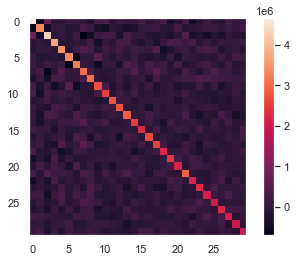

In [42]:
plt.imshow(V[:, :30].T @ V[:, :30])
plt.colorbar()
plt.grid()

In [71]:
r=1
reconstructed = sampled_U[:, :r] @ np.diag(s[:r]) @ V.T[:r, :]

In [72]:
covars = np.array([np.cov(observed[i], reconstructed[i])[0, 1] for i in range(num_random_pixels)])
covars.min(), covars.mean()

(-0.01356138884516776, 0.1489766093830028)

In [83]:
(np.var(reconstructed, axis=1) - covars) / (np.var(reconstructed, axis=1)) * 100

array([-3.56043937e+00, -8.17283676e+01, -6.26594874e+00, -3.45435230e+01,
       -3.26354146e+01, -1.48675935e+02,  2.04649022e+02,  4.11051729e+00,
       -1.91387879e+00, -2.41236746e+01,  1.65982898e+01,  3.26962319e+01,
       -2.80098688e+00, -4.94282765e+00,  5.34497996e+01,  1.12799957e+02,
        3.55122669e+01, -3.87746781e-01,  3.30246701e+01, -6.87706490e+02,
        3.53497880e+01,  6.66766262e+02,  1.44458807e+00, -1.17462498e+01,
       -2.34140414e+01,  2.94774585e+03,  3.29763286e+00,  2.77056603e+03,
        5.99981638e+01, -1.40841813e+02, -3.76100239e+00,  3.24273711e+01,
        1.17356169e+01,  1.16710074e+01, -6.53503593e+01, -2.75493373e+00,
        6.53360481e+01,  3.88460168e+01,  9.62900169e+00, -1.18312983e+01,
       -1.04920387e+02, -1.46415301e+01,  1.23232799e+02, -2.16673439e+01,
       -3.32774895e+00, -4.76772420e+01,  6.06202348e+00,  2.33107866e+01,
        5.90906494e+01, -1.23541142e+01, -7.28232424e+01,  1.66744847e+00,
       -7.50428882e+00,  

In [85]:
observed_var.mean()

0.7669597937930519

In [51]:
reconstructed_var.mean()

0.45890270247723264

In [98]:
V[~np.array(invalid_times)].T @ V[~np.array(invalid_times)] / 1_000_000

array([[ 4.65101828,  0.48691575, -0.82374718, ..., -0.09845709,
        -0.03580374,  0.18716585],
       [ 0.48691575,  3.24793593, -0.43639117, ...,  0.10512091,
        -0.01065122,  0.04949298],
       [-0.82374718, -0.43639117,  4.17340336, ...,  0.01183673,
        -0.08423668, -0.27332717],
       ...,
       [-0.09845709,  0.10512091,  0.01183673, ...,  1.68669326,
         0.13173606,  0.0470882 ],
       [-0.03580374, -0.01065122, -0.08423668, ...,  0.13173606,
         1.41651377,  0.12991603],
       [ 0.18716585,  0.04949298, -0.27332717, ...,  0.0470882 ,
         0.12991603,  1.57693958]])

In [190]:
covars

array([0.38810774, 0.09762039, 0.46879991, 0.61269023, 0.76799459,
       0.51855799, 0.2418385 , 0.24193233, 0.32032204, 0.17192041,
       0.11661019, 0.1568451 , 0.55789874, 0.19485214, 0.66076652,
       0.21866204, 0.57002035, 0.06838001, 0.73601073, 0.13372316,
       0.10461304, 0.10347787, 0.19049744, 0.4122371 , 0.19510734,
       0.11688055, 0.48971115, 0.13320731, 0.65480702, 0.96281762,
       0.17241075, 0.1346395 , 0.14909826, 0.22199805, 0.46504138,
       0.17106037, 0.60499729, 0.57375363, 0.14623592, 0.1423651 ,
       0.21473495, 0.42470115, 0.11390287, 0.20130569, 0.15999744,
       0.18417615, 0.16277638, 0.11807619, 0.09711807, 2.61133123,
       0.39417588, 0.61585144, 0.81592644, 0.15933708, 0.21210225,
       0.26663436, 0.22110412, 0.137752  , 0.38215625, 0.16589752,
       0.42691861, 0.9189535 , 0.49697345, 0.25303573, 1.76208175,
       0.15898047, 0.29819274, 0.41609602, 0.49952105, 0.15619277,
       0.47119764, 0.3596778 , 0.18108498, 0.36090881, 0.22211

In [188]:
np.mean([pearsonr(observed[i, ~np.array(invalid_times)], reconstructed[i, ~np.array(invalid_times)])[0] for i in range(num_random_pixels)])

0.7219820085264801

In [137]:
observed[:, ~np.array(invalid_times)].shape, reconstructed[:, ~np.array(invalid_times)].shape

((1000, 17400), (1000, 17400))

# Misc

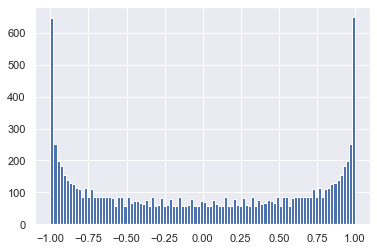

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# this is the distribution of V if it's sinusoidal
bluh = np.sin(np.arange(10000))
plt.hist(bluh, bins=100);

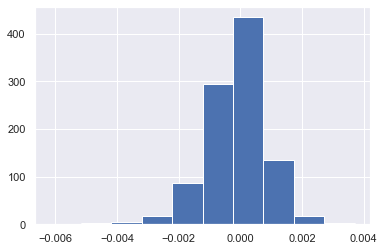

In [59]:
plt.hist(sampled_U[:, 5]);

In [68]:
reconstructed

array([[-1.21193976, -1.20358923, -1.15637819, ..., -0.27973983,
        -0.44221404, -0.58857214],
       [-1.02706684, -1.07799596, -1.08943528, ...,  0.01507438,
        -0.09510266, -0.2033949 ],
       [ 1.40875136,  1.43156   ,  1.46250984, ...,  0.8523714 ,
         0.87568094,  0.91343639],
       ...,
       [-1.38564017, -1.70213716, -1.91043752, ...,  0.18949098,
        -0.25677179, -0.71414866],
       [ 0.64328634,  0.64131755,  0.58538696, ..., -0.15329244,
        -0.08243787, -0.01374607],
       [ 0.06015386,  0.20414564,  0.31254273, ..., -0.83071664,
        -0.62853471, -0.41272084]])

In [71]:
observed

array([[-1.0728001 , -1.02328724, -0.90697521, ..., -0.71377605,
        -1.17754215, -1.57478375],
       [-0.54683031, -0.55019296, -0.52778734, ..., -1.04520334,
        -1.18890299, -1.1404487 ],
       [ 1.60315107,  1.5974481 ,  1.60398458, ...,  0.87009405,
         0.89622472,  0.93352102],
       ...,
       [-1.86142532, -1.92459099, -1.91633598, ...,  1.49161537,
         0.70979126, -0.03205101],
       [-0.4467025 , -0.48763992, -0.50016739, ...,  0.46913765,
         0.46263168,  0.46399353],
       [-1.04339155, -0.8183473 , -0.57130369, ..., -0.42618688,
        -0.38534864, -0.24618276]])

(array([33., 19., 13., 12., 11.,  7., 10., 16., 15., 32.]),
 array([-12.76559492,  -8.732221  ,  -4.69884707,  -0.66547315,
          3.36790077,   7.4012747 ,  11.43464862,  15.46802255,
         19.50139647,  23.53477039,  27.56814432]),
 <BarContainer object of 10 artists>)

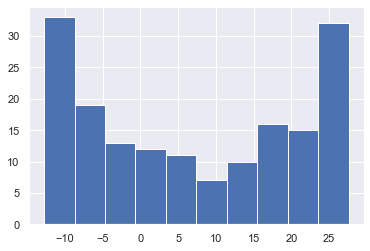

In [74]:
plt.hist(V[:24*7, 2])

# test whether my estimate of explained variance matches typical definition

In [16]:
from matplotlib import image

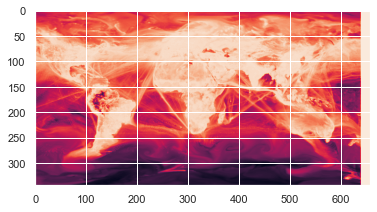

In [28]:
mat = image.imread(r".\figures\2019.6.1_map.png")[150:-150, 200:-200, 0]
plt.imshow(mat)

In [57]:
mean_col = np.mean(mat, axis=1, keepdims=True)
mat -= mean_col

In [29]:
mat.shape

(344, 658)

In [58]:
U, s, Vt = np.linalg.svd(mat, full_matrices=False)

In [76]:
total_var = sum(s**2)
explained_var = []
sum_var_over_sum_var = []
for rank in range(0, 50):
    print(rank)
    reconstructed = U[:, :rank] @ np.diag(s[:rank]) @ Vt[:rank, :]
    observed_var = np.var(mat, axis=1)
    recon_var = np.var(reconstructed, axis=1)
    sum_var_over_sum_var.append(np.sum(recon_var[::10]) / np.sum(observed_var[::10]))
    explained_var.append(sum(s[:rank]**2) / total_var)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


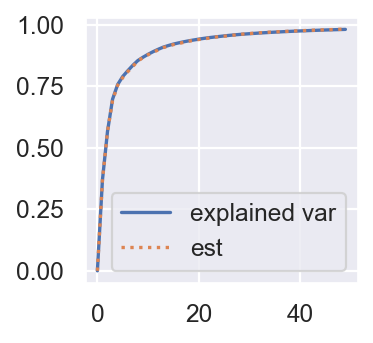

In [77]:
plt.figure(figsize=(2.2,2.2), dpi=160)
plt.plot(explained_var, label="explained var")
plt.plot(sum_var_over_sum_var, ":", label="est")
plt.legend()
plt.show()

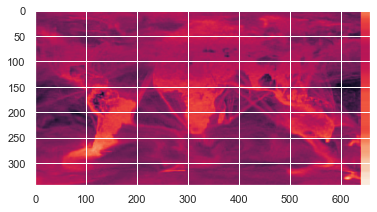

In [78]:
plt.imshow(reconstructed)